# Using GPs with custom kernels, produce spectra

and see if the spectra look different with different kernel hyperparameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=1.8)
sns.set_style('white')

import fsps
from astropy.cosmology import WMAP9 as cosmo

In [2]:
sp = fsps.StellarPopulation(imf_type=2, zcontinuous=1)
sp.params['imf_type'] = 1 # Chabrier
sp.params['logzsol'] = 0.0 # Solar metallicity
sp.params['dust_type'] = 2 # Calzetti
sp.params['dust2'] = 0.2

In [3]:
# Creating a base class that simplifies a lot of things. 
# The way this is set up, you can pass a kernel as an argument 
# to compute the covariance matrix and draw samples from it. 

class simple_GP_sfh():
    
    """
    A class that creates and holds information about a specific 
    kernel, and can generate samples from it.
    
    Attributes
    ----------
    tarr: fiducial time array used to draw samples
    kernel: accepts an input function as an argument,
        of the format:
        
            def kernel_function(delta_t, **kwargs):
                ... function interior ...
                return kernel_val[array of len(delta_t)]
    
    Methods
    -------
    get_covariance_matrix 
        [although this has double for loops for maximum flexibility 
        with generic kernel functions, it only has to be computed once,
        which makes drawing random samples super fast once it's computed.]
    sample_kernel
    plot_samples
    plot_kernel
    [to-do] condition on data
    
    """
    
    def __init__(self):
        
        self.tarr = np.linspace(0,10,1000)
        self.kernel = []
        self.covariance_matrix = []

    def get_covariance_matrix(self, **kwargs):
        """
        Evaluate covariance matrix with a particular kernel
        """
            
        cov_matrix = np.zeros((len(self.tarr),len(self.tarr)))
        for i in range(len(cov_matrix)):
            for j in range(len(cov_matrix)):
                    cov_matrix[i,j] = self.kernel(self.tarr[i] - self.tarr[j], **kwargs)
                    
        return cov_matrix
    
    def sample_kernel(self, nsamp = 100, random_seed = 42, **kwargs):
        
        mean_array = np.zeros_like(self.tarr)
        if len(self.covariance_matrix) == 0:
            self.covariance_matrix = self.get_covariance_matrix(**kwargs)
#         else: 
#             print('using precomputed covariance matrix')
            
        np.random.seed(random_seed)
        samples = np.random.multivariate_normal(mean_array,self.covariance_matrix,size=nsamp)
        
        return samples
    
    def plot_samples(self, nsamp = 100, random_seed = 42, plot_samples=5,plim=2, plotlog=False, **kwargs):
        
        samples = self.sample_kernel(nsamp = nsamp, random_seed = random_seed, **kwargs)
        
        plt.figure(figsize=(12,6))
        if plotlog == True:
            plt.plot(self.tarr, 10**samples.T[0:,0:plot_samples],'-',alpha=0.7,lw=1)
            plt.plot(self.tarr, 10**np.nanpercentile(samples.T,50,axis=1),'k',lw=3,label='median')
            plt.xlabel('time [arbitrary units]')
            plt.ylabel('some quantity of interest')
        else:
            plt.plot(self.tarr, samples.T[0:,0:plot_samples],'-',alpha=0.7,lw=1)
            plt.plot(self.tarr, np.nanpercentile(samples.T,50,axis=1),'k',lw=3,label='median')
            plt.fill_between(self.tarr, np.nanpercentile(samples.T,16,axis=1), 
                            np.nanpercentile(samples.T,84,axis=1),color='k',alpha=0.1,label='1$\sigma$')
            plt.xlabel('time [arbitrary units]')
            plt.ylabel('some quantity of interest')
            plt.legend(edgecolor='w');
            plt.ylim(-plim,plim);plt.title([kwargs])
        plt.show()
        
    def plot_kernel(self, deltat = np.round(np.arange(-10,10,0.1),1), **kwargs):
        
        plt.figure(figsize=(12,6))
        plt.plot(deltat, self.kernel(deltat, **kwargs),lw=3,
                 label=kwargs)
        plt.xlabel('$\Delta t$')
        plt.ylabel('covariance');plt.title(kwargs)
        #plt.text(-9,0.23,'Past');plt.text(7,0.23,'Future')
        plt.show()


# Let's start with the regulator model. 


For $\tau = |t-t'|$,
$$
C(\tau) = \frac{\sigma^2}{(\tau_x^2 - \tau_{eq}^2)} \left( \tau_x \exp{(-\frac{\tau}{\tau_x})} - \tau_{eq}\exp{(-\frac{\tau}{\tau_{eq}})} \right)
$$

In [4]:
def regulator_model_kernel(delta_t, sigma=1.0, tau_eq = 5.0, tau_x = 0.5):
    """
    A basic implementation of the regulator model kernel, with three parameters:
    sigma: \sigma, the amount of overall variance
    tau_eq: equilibrium timescale
    tau_x: inflow correlation timescale (includes 2pi factor)
    
    """

    kernel_val = sigma**2 / (tau_x**2 - tau_eq**2) * (tau_x * np.exp(-np.abs(delta_t) / tau_x) - tau_eq * np.exp(-np.abs(delta_t) / tau_eq))
    return kernel_val

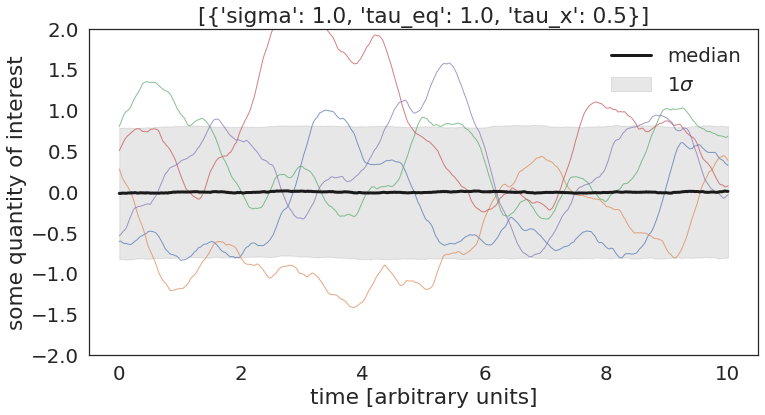

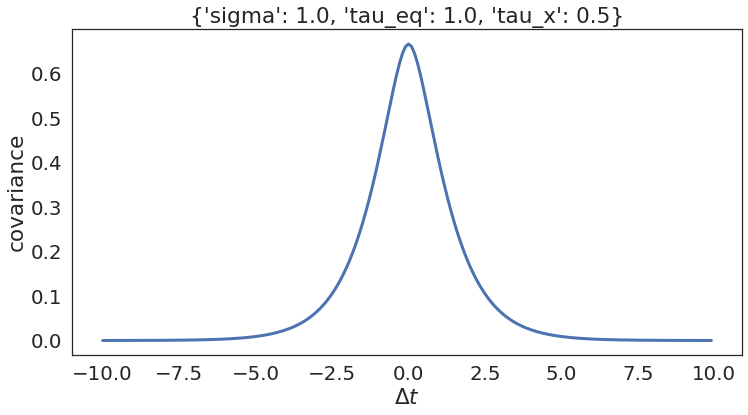

In [5]:
cls1 = simple_GP_sfh()
cls1.kernel = regulator_model_kernel
cls1.plot_samples(sigma=1.0, tau_eq=1.0, tau_x = 0.5, nsamp = 10000, random_seed=42,plim=2)
cls1.plot_kernel(sigma=1.0, tau_eq=1.0, tau_x = 0.5)

Assuming a constant SFH, and considering the samples from the GP as perturbations in log SFR around the median SFH, we now get draws from the GP and generate corresponding spectra

In [6]:
zval = 1.0
t_univ = cosmo.age(zval).value
tarr = np.linspace(0,t_univ, 1000)
basesfh = np.ones_like(tarr)* 1.0 # constant SFH, 1 Msun/yr

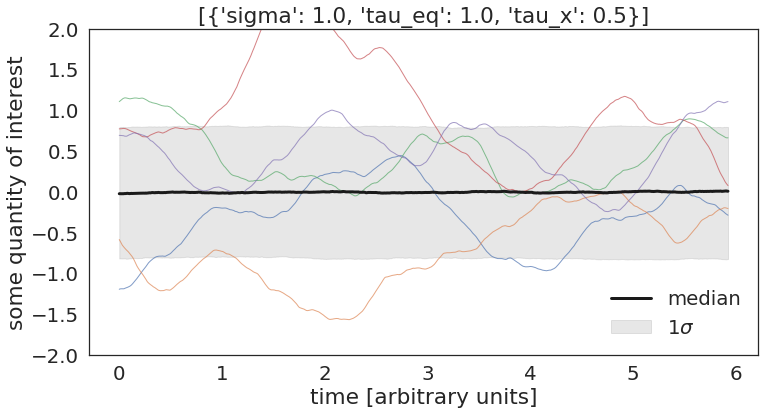

In [7]:
cls1 = simple_GP_sfh()
cls1.tarr = tarr
cls1.kernel = regulator_model_kernel
cls1.plot_samples(sigma=1.0, tau_eq=1.0, tau_x = 0.5, nsamp = 10000, random_seed=42,plim=2)
#cls1.plot_kernel(sigma=1.0, tau_eq=1.0, tau_x = 0.5)

samples = cls1.sample_kernel(sigma=1.0, tau_eq=1.0, tau_x = 0.5, nsamp = 10000, random_seed=42)

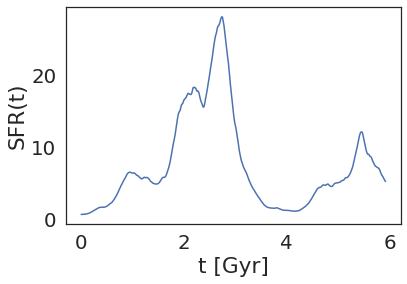

In [8]:
sfh = 10**(basesfh+samples[0, 0:])
plt.plot(tarr, sfh)
plt.xlabel('t [Gyr]')
plt.ylabel('SFR(t)')
plt.show()

In [9]:
sp.params['sfh'] = 3
sp.set_tabular_sfh(tarr, sfh)
lam, spec = sp.get_spectrum(tage = t_univ)
mstar = sp.stellar_mass

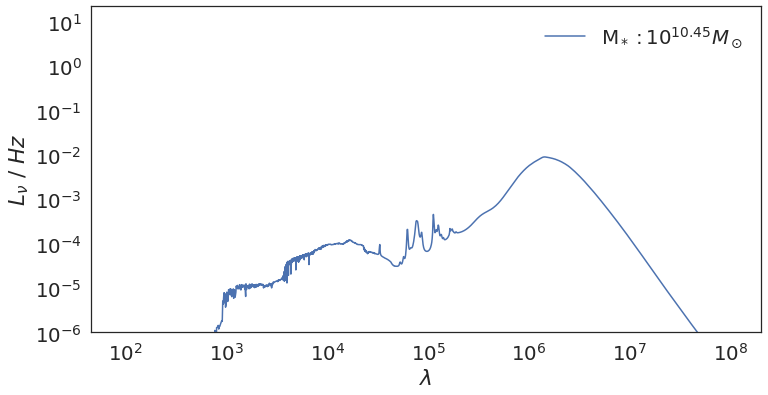

In [10]:
plt.figure(figsize=(12,6))
plt.loglog(lam, spec, label='M$_*: 10^{%.2f} M_\odot$' %(np.log10(mstar)))
plt.ylim(1e-6,)
plt.legend(edgecolor='w')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$L_\nu~/~Hz$')
plt.show()

# now let's generate spectra for a bunch of SFHs, varying the regulator model parameters.

In [11]:
nsamp = 10

cls1 = simple_GP_sfh()
cls1.tarr = tarr
cls1.kernel = regulator_model_kernel
cls1.sigma = 1.0
cls1.tau_eq = 1.0
cls1.tau_x = 0.5
samples_param1 = cls1.sample_kernel(sigma=cls1.sigma, tau_eq=cls1.tau_eq, tau_x = cls1.tau_x, 
                                    nsamp = nsamp, random_seed=42)


cls2 = simple_GP_sfh()
cls2.tarr = tarr
cls2.kernel = regulator_model_kernel
cls2.sigma = 1.0
cls2.tau_eq = 1.0
cls2.tau_x = 0.9
samples_param2 = cls2.sample_kernel(sigma=cls2.sigma, tau_eq=cls2.tau_eq, tau_x = cls2.tau_x, 
                                    nsamp = nsamp, random_seed=42)


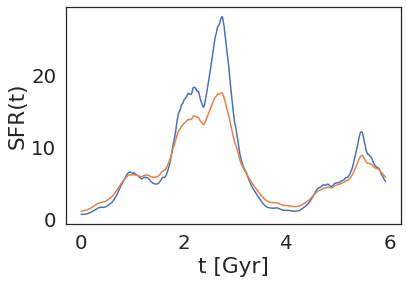

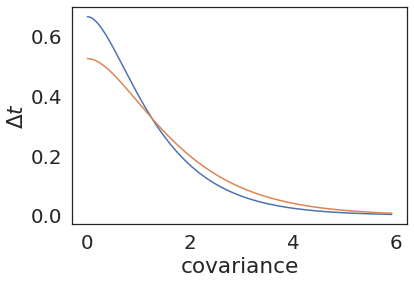

In [12]:
sfh_param1 = 10**(basesfh+samples_param1[0, 0:])
sfh_param2 = 10**(basesfh+samples_param2[0, 0:])
plt.plot(tarr, sfh_param1)
plt.plot(tarr, sfh_param2)
plt.xlabel('t [Gyr]')
plt.ylabel('SFR(t)')
plt.show()

plt.plot(tarr, cls1.kernel(tarr, sigma = cls1.sigma, tau_eq = cls1.tau_eq, tau_x = cls1.tau_x))
plt.plot(tarr, cls2.kernel(tarr, sigma = cls2.sigma, tau_eq = cls2.tau_eq, tau_x = cls2.tau_x))
plt.xlabel('covariance')
plt.ylabel('$\Delta t$')
plt.show()

In [13]:
spec_param1 = np.zeros((len(spec), nsamp))
mstar_param1 = np.zeros((nsamp,))

spec_param2 = np.zeros((len(spec), nsamp))
mstar_param2 = np.zeros((nsamp,))

for i in range(nsamp):
    
    sp.params['sfh'] = 3
    
    sfh_param1 = 10**(basesfh+samples_param1[i, 0:])
    sp.set_tabular_sfh(tarr, sfh_param1)
    _, spec_param1[0:,i] = sp.get_spectrum(tage = t_univ)
    mstar_param1[i] = sp.stellar_mass
    
    
    sfh_param2 = 10**(basesfh+samples_param2[i, 0:])
    sp.set_tabular_sfh(tarr, sfh_param2)
    _, spec_param2[0:,i] = sp.get_spectrum(tage = t_univ)
    mstar_param2[i] = sp.stellar_mass

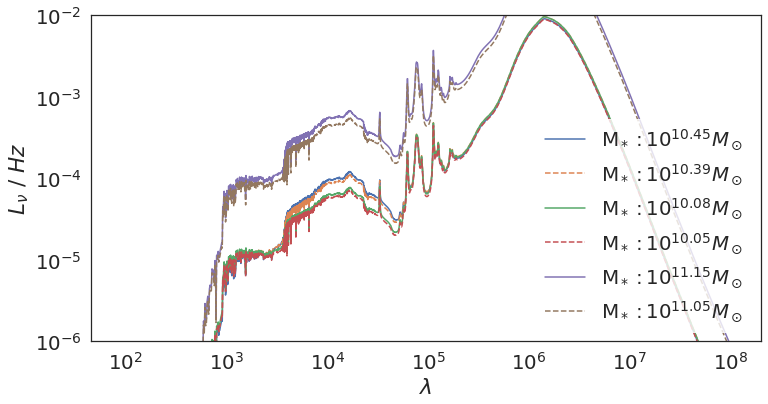

In [14]:
plt.figure(figsize=(12,6))
for i in range(3):
    plt.loglog(lam, spec_param1[0:,i], label='M$_*: 10^{%.2f} M_\odot$' %(np.log10(mstar_param1[i])))
    plt.loglog(lam, spec_param2[0:,i],'--', label='M$_*: 10^{%.2f} M_\odot$' %(np.log10(mstar_param2[i])))
plt.ylim(1e-6,1e-2)
plt.legend(edgecolor='w')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$L_\nu~/~Hz$')
plt.show()

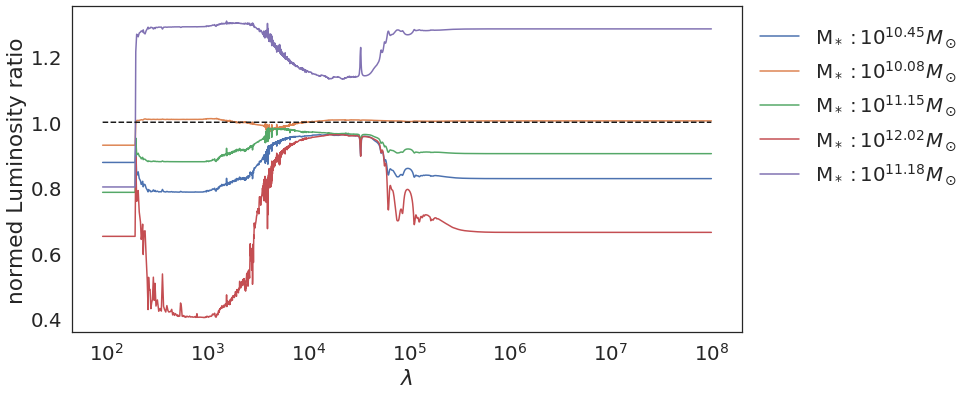

In [15]:
plt.figure(figsize=(12,6))
for i in range(5):
    normed_spec1 = spec_param1[0:,i] / mstar_param1[i]
    normed_spec2 = spec_param2[0:,i] / mstar_param2[i]
    plt.plot(lam, normed_spec1/normed_spec2, label='M$_*: 10^{%.2f} M_\odot$' %(np.log10(mstar_param1[i])))
#plt.ylim(1e-6,1e-2)
plt.xscale('log')
plt.plot(lam, np.ones_like(lam),'k--')
plt.legend(edgecolor='w',bbox_to_anchor=(1,1))
plt.xlabel(r'$\lambda$')
plt.ylabel('normed Luminosity ratio')
plt.show()

now bring it all together and see what the median behaviour looks like for an ensemble of SFHs.

In [16]:
nsamp = 1000

cls1 = simple_GP_sfh()
cls1.tarr = tarr
cls1.kernel = regulator_model_kernel
cls1.sigma = 1.0
cls1.tau_eq = 1.0
cls1.tau_x = 0.5
samples_param1 = cls1.sample_kernel(sigma=cls1.sigma, tau_eq=cls1.tau_eq, tau_x = cls1.tau_x, 
                                    nsamp = nsamp, random_seed=42)


cls2 = simple_GP_sfh()
cls2.tarr = tarr
cls2.kernel = regulator_model_kernel
cls2.sigma = 1.0
cls2.tau_eq = 1.0
cls2.tau_x = 0.9
samples_param2 = cls2.sample_kernel(sigma=cls2.sigma, tau_eq=cls2.tau_eq, tau_x = cls2.tau_x, 
                                    nsamp = nsamp, random_seed=42)

spec_param1 = np.zeros((len(spec), nsamp))
mstar_param1 = np.zeros((nsamp,))

spec_param2 = np.zeros((len(spec), nsamp))
mstar_param2 = np.zeros((nsamp,))

spec_ratios = np.zeros((len(spec), nsamp))

for i in range(nsamp):
    
    sp.params['sfh'] = 3
    
    sfh_param1 = 10**(basesfh+samples_param1[i, 0:])
    sp.set_tabular_sfh(tarr, sfh_param1)
    _, spec_param1[0:,i] = sp.get_spectrum(tage = t_univ)
    mstar_param1[i] = sp.stellar_mass
    
    
    sfh_param2 = 10**(basesfh+samples_param2[i, 0:])
    sp.set_tabular_sfh(tarr, sfh_param2)
    _, spec_param2[0:,i] = sp.get_spectrum(tage = t_univ)
    mstar_param2[i] = sp.stellar_mass
    
    
    normed_spec1 = spec_param1[0:,i] / mstar_param1[i]
    normed_spec2 = spec_param2[0:,i] / mstar_param2[i]
    spec_ratios[0:,i] = normed_spec1/normed_spec2
    
    if (i%100 == 0):
        print(i/nsamp)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


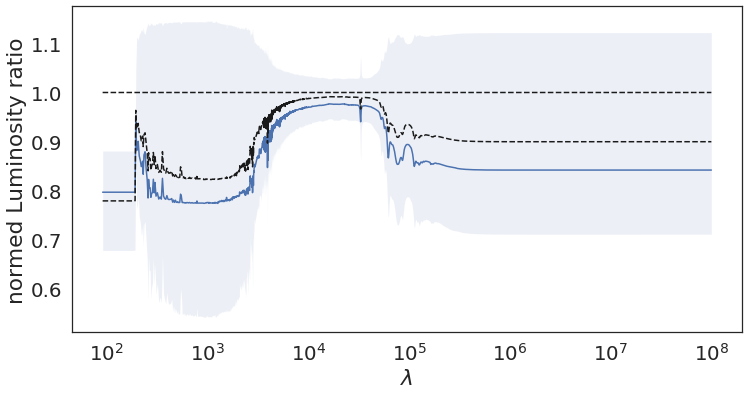

In [17]:
plt.figure(figsize=(12,6))
plt.plot(lam, np.nanmedian(spec_ratios,1))
plt.plot(lam, np.nanmean(spec_ratios,1),'k--')
plt.fill_between(lam, np.nanpercentile(spec_ratios,16,1),
                np.nanpercentile(spec_ratios,84,1),alpha=0.1)
plt.xscale('log')
plt.plot(lam, np.ones_like(lam),'k--')
plt.xlabel(r'$\lambda$')
plt.ylabel('normed Luminosity ratio')
plt.show()

# formalise this:

In [18]:
def compare_regulator_models(params1, params2, nsamp, sp=sp, tarr = tarr, basesfh = basesfh):

    sigma1, tau_eq1, tau_x1 = params1
    cls1 = simple_GP_sfh()
    cls1.tarr = tarr
    cls1.kernel = regulator_model_kernel
    cls1.sigma = sigma1
    cls1.tau_eq = tau_eq1
    cls1.tau_x = tau_x1
    samples_param1 = cls1.sample_kernel(sigma=cls1.sigma, tau_eq=cls1.tau_eq, tau_x = cls1.tau_x, 
                                        nsamp = nsamp, random_seed=42)

    sigma2, tau_eq2, tau_x2 = params2
    cls2 = simple_GP_sfh()
    cls2.tarr = tarr
    cls2.kernel = regulator_model_kernel
    cls2.sigma = sigma2
    cls2.tau_eq = tau_eq2
    cls2.tau_x = tau_x2
    samples_param2 = cls2.sample_kernel(sigma=cls2.sigma, tau_eq=cls2.tau_eq, tau_x = cls2.tau_x, 
                                        nsamp = nsamp, random_seed=42)

    spec_param1 = np.zeros((len(spec), nsamp))
    mstar_param1 = np.zeros((nsamp,))

    spec_param2 = np.zeros((len(spec), nsamp))
    mstar_param2 = np.zeros((nsamp,))

    spec_ratios = np.zeros((len(spec), nsamp))

    for i in range(nsamp):

        sp.params['sfh'] = 3

        sfh_param1 = 10**(basesfh+samples_param1[i, 0:])
        sp.set_tabular_sfh(tarr, sfh_param1)
        _, spec_param1[0:,i] = sp.get_spectrum(tage = t_univ)
        mstar_param1[i] = sp.stellar_mass


        sfh_param2 = 10**(basesfh+samples_param2[i, 0:])
        sp.set_tabular_sfh(tarr, sfh_param2)
        _, spec_param2[0:,i] = sp.get_spectrum(tage = t_univ)
        mstar_param2[i] = sp.stellar_mass


        normed_spec1 = spec_param1[0:,i] / mstar_param1[i]
        normed_spec2 = spec_param2[0:,i] / mstar_param2[i]
        spec_ratios[0:,i] = normed_spec1/normed_spec2

#         if (i%100 == 0):
#             print(i/nsamp)
            
    return spec_ratios

def plot_spec_diff(spec_ratios, lam = lam):
    
    plt.figure(figsize=(12,6))
    plt.plot(lam, np.nanmedian(spec_ratios,1))
    plt.plot(lam, np.nanmean(spec_ratios,1),'k--')
    plt.fill_between(lam, np.nanpercentile(spec_ratios,16,1),
                    np.nanpercentile(spec_ratios,84,1),alpha=0.1)
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(lam, np.ones_like(lam),'k--')
    plt.xlabel(r'$\lambda$')
    plt.ylabel('normed Luminosity ratio')
    plt.show()

## 1. let's just confirm that the same model gives a net difference of 0:

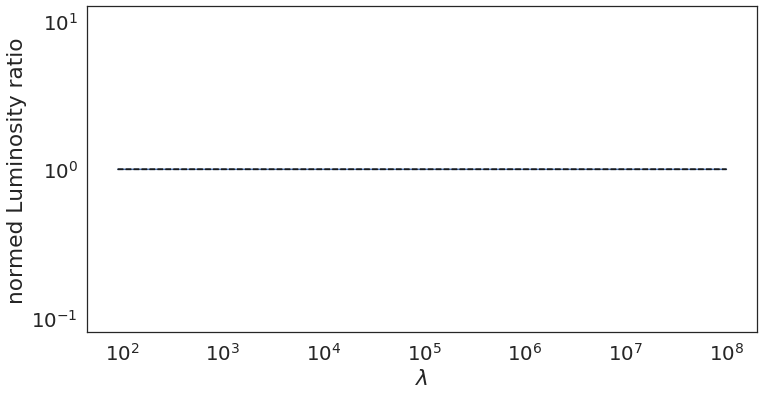

In [19]:
spec_ratios = compare_regulator_models(params1 = (1.0,1.0,0.1), params2 = (1.0,1.0,0.1), nsamp = 1000, sp=sp)
plot_spec_diff(spec_ratios, lam=lam)

## 2. what happens when we increase/decrease sigma - just make things more/less bursty

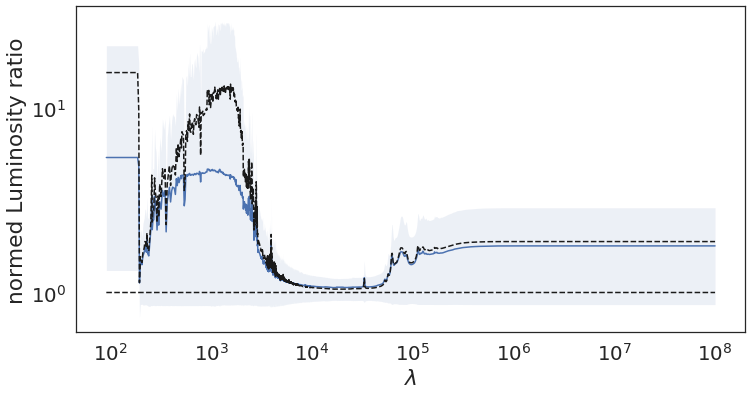

In [20]:
spec_ratios_case2 = compare_regulator_models(params1 = (1.0,1.0,0.5), params2 = (2.0,1.0,0.5), nsamp = 1000, sp=sp)
plot_spec_diff(spec_ratios_case2, lam=lam)

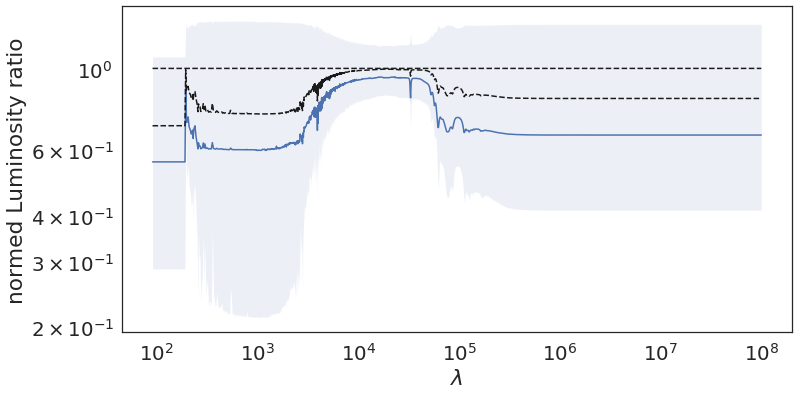

In [21]:
spec_ratios = compare_regulator_models(params1 = (1.0,1.0,0.5), params2 = (0.5,1.0,0.5), nsamp = 1000, sp=sp)
plot_spec_diff(spec_ratios, lam=lam)

## 3. what happens when we increase tau_eq - change the equilibrium timescale

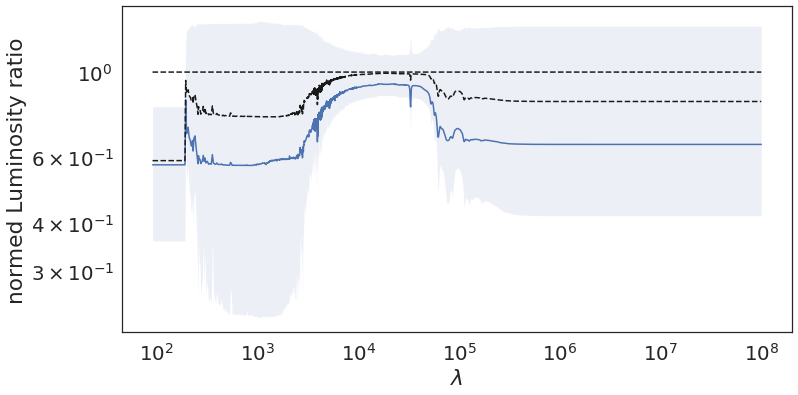

In [22]:
spec_ratios = compare_regulator_models(params1 = (1.0,1.0,0.5), params2 = (1.0,3.0,0.5), nsamp = 1000, sp=sp)
plot_spec_diff(spec_ratios, lam=lam)

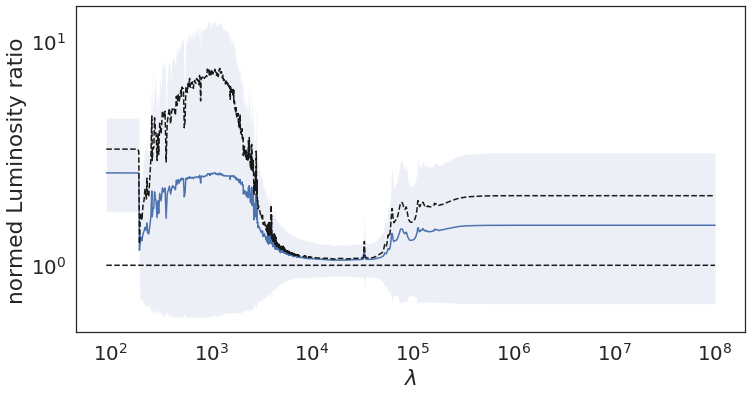

In [23]:
spec_ratios_case3 = compare_regulator_models(params1 = (1.0,1.0,0.5), params2 = (1.0,0.3,0.5), nsamp = 1000, sp=sp)
plot_spec_diff(spec_ratios_case3, lam=lam)

## 4. what happens when we increase tau_x - change the inflow timescale

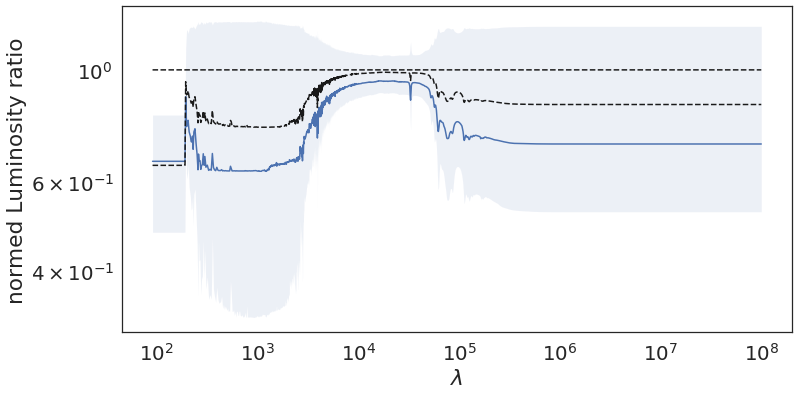

In [24]:
spec_ratios = compare_regulator_models(params1 = (1.0,1.0,0.5), params2 = (1.0,1.0,0.5*3.0), nsamp = 1000, sp=sp)
plot_spec_diff(spec_ratios, lam=lam)

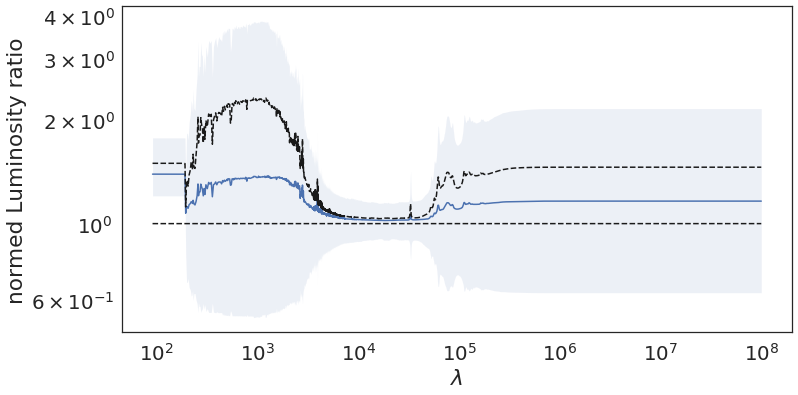

In [25]:
spec_ratios_case4 = compare_regulator_models(params1 = (1.0,1.0,0.5), params2 = (1.0,1.0,0.5/3.0), nsamp = 1000, sp=sp)
plot_spec_diff(spec_ratios_case4, lam=lam)

# now check whether the different scenarios look qualitatively different

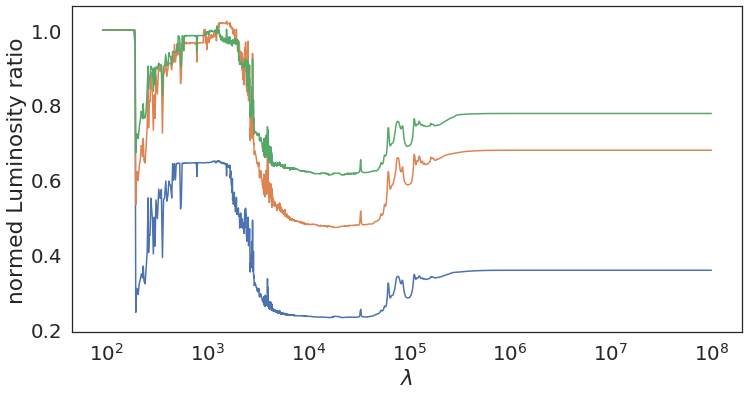

In [26]:
# normalising at a particular wavelength to better compare the overall shapes

tarr = np.linspace(0,t_univ, 1000)
basesfh = np.ones_like(tarr)* 1.0 # constant SFH, 1 Msun/yr

spec_ratios_case2 = compare_regulator_models(params1 = (1.0,1.0,0.5), params2 = (2.0,1.0,0.5), nsamp = 100, sp=sp, tarr = tarr, basesfh = basesfh)
spec_ratios_case3 = compare_regulator_models(params1 = (1.0,1.0,0.5), params2 = (1.0,0.3,0.5), nsamp = 100, sp=sp, tarr = tarr, basesfh = basesfh)
spec_ratios_case4 = compare_regulator_models(params1 = (1.0,1.0,0.5), params2 = (1.0,1.0,0.5/10.0), nsamp = 100, sp=sp, tarr = tarr, basesfh = basesfh)

norm_at_x = 1e2
norm_at_x_index = np.argmin(np.abs(lam-norm_at_x))

plt.figure(figsize=(12,6))
plt.plot(lam, np.nanmedian(spec_ratios_case2,1)/ np.nanmedian(spec_ratios_case2, 1)[norm_at_x_index])
plt.plot(lam, np.nanmedian(spec_ratios_case3,1)/ np.nanmedian(spec_ratios_case3, 1)[norm_at_x_index])
plt.plot(lam, np.nanmedian(spec_ratios_case4,1)/ np.nanmedian(spec_ratios_case4, 1)[norm_at_x_index])
# plt.plot(lam, np.nanmean(spec_ratios,1),'k--')
# plt.fill_between(lam, np.nanpercentile(spec_ratios,16,1),
#                 np.nanpercentile(spec_ratios,84,1),alpha=0.1)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel('normed Luminosity ratio')
plt.show()

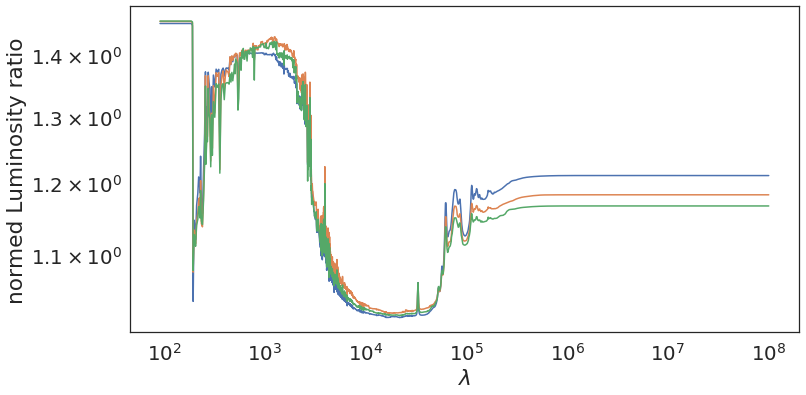

In [27]:
# or, as an alternative, eyeballing numbers to try to get the curves to roughly match up. 
# this can be better formulated as a minimization problem, but takes too long to run

tarr = np.linspace(0,t_univ, 1000)
basesfh = np.ones_like(tarr)* 1.0 # constant SFH, 1 Msun/yr

spec_ratios_case2 = compare_regulator_models(params1 = (1.0,1.0,0.5), params2 = (1.25,1.0,0.5), nsamp = 1000, sp=sp, tarr = tarr, basesfh = basesfh)
spec_ratios_case3 = compare_regulator_models(params1 = (1.0,1.0,0.5), params2 = (1.0,0.6,0.5), nsamp = 1000, sp=sp, tarr = tarr, basesfh = basesfh)
spec_ratios_case4 = compare_regulator_models(params1 = (1.0,1.0,0.5), params2 = (1.0,1.0,0.5/3.7), nsamp = 1000, sp=sp, tarr = tarr, basesfh = basesfh)

plt.figure(figsize=(12,6))
plt.plot(lam, np.nanmedian(spec_ratios_case2,1))
plt.plot(lam, np.nanmedian(spec_ratios_case3,1))
plt.plot(lam, np.nanmedian(spec_ratios_case4,1))
# plt.plot(lam, np.nanmean(spec_ratios,1),'k--')
# plt.fill_between(lam, np.nanpercentile(spec_ratios,16,1),
#                 np.nanpercentile(spec_ratios,84,1),alpha=0.1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel('normed Luminosity ratio')
plt.show()